In [2]:
import pybullet as p
import pybullet_data
import time
import numpy as np
import random
import math
import roboticstoolbox as rtb
import spatialmath as sm
from matplotlib import pylab
from roboticstoolbox.tools.types import ArrayLike
from typing import Union

class Joint(object):
    def __init__(self, physics_client, model_id, joint_id, limits):
        self.physics_client = physics_client
        self.model_id = model_id
        self.jid = joint_id
        self.limits = limits

    def get_position(self):
        joint_state = self.physics_client.getJointState(self.model_id, self.jid)
        return joint_state[0]

    def set_position(self, position, max_force=100.):
        self.physics_client.setJointMotorControl2(
            self.model_id,
            self.jid,
            controlMode=self.physics_client.POSITION_CONTROL,
            targetPosition=position,
            force=max_force,
            positionGain=0.5,
            velocityGain=1.0
        )

class Robot():
	def __init__(self, physics_client, model_path, rtb_model, initial_base_pos, initial_base_orn):
		self.physics_client = physics_client
		self.model_id = self.physics_client.loadURDF(model_path, initial_base_pos, initial_base_orn, useFixedBase=True)
		self.rtb_model = rtb_model
			
		self._time_step = 1. / 240.
		self._left_finger_id = 9
		self._right_finger_id = 10

	def load_model(self):
		joints = {}
		for i in range(self.physics_client.getNumJoints(self.model_id)):
			joint_info = self.physics_client.getJointInfo(self.model_id, i)
			joint_limits = {
				'lower': joint_info[8], 
				'upper': joint_info[9],
				'force': joint_info[10]
			}
			joints[i] = Joint(self.physics_client, self.model_id, i, joint_limits)
			# print(joint_info)
		
		self.rtb_model.qlim = np.array([[joints[i].limits['lower'], joints[i].limits['upper']] for i in range(7)]).T
		self.joints = joints
		return self.model_id

	def reset(self, initial_positions):
		for jid in range(len(initial_positions)):
			self.physics_client.resetJointState(self.model_id, jid, initial_positions[jid])
		
		self._left_finger = self.joints[self._left_finger_id]
		self._right_finger = self.joints[self._right_finger_id]

	def run(self, duration):
		for _ in range(int(duration / self._time_step)):
			self.physics_client.stepSimulation()

	def get_pos(self):
		return [self.joints[i].get_position() for i in range(7)]

	def get_ee_pos(self):
		ee_pos, ee_orn = self.physics_client.getLinkState(self.model_id, 11)[:2]
		return ee_pos, ee_orn

	def open_gripper(self):
		print('Opening gripper...')
		self._left_finger.set_position(self._left_finger.limits['upper'])
		self._right_finger.set_position(self._left_finger.limits['upper'])
		
		self.run(0.2)

	def close_gripper(self):
		print('Closing gripper...')
		self._left_finger.set_position(self._left_finger.limits['lower'])
		self._right_finger.set_position(self._left_finger.limits['lower'])

		self.run(0.2)

	def ikine(self, T: sm.SE3, q0: Union[ArrayLike, None]=None, itr: int=100) -> np.ndarray:
		"""
		Parameters
		----------
		T : sm.SE3
			The desired end-effector pose.
		q0 : ArrayLike, optional
			The initial guess for the joint angles. If None, the initial guess is set to the zero vector.
		itr : int, optional
			The number of iterations to attempt in case the initial IK solution is invalid.
		
		Returns
		-------
		q : np.ndarray
			The joint angles that achieve the desired end-effector pose.
		"""
		# if q0 is None:
		# 	q0 = np.zeros(7)
		
		# lower_limit_joints = [self.joints[i].limits['lower'] for i in range(7)]
		# upper_limit_joints = [self.joints[i].limits['upper'] for i in range(7)]

		# succes = False
		# for _ in range(itr):
		# 	ik_solution = self.rtb_model.ikine_LM(T, q0=q0, joint_limits=True)
		# 	if ik_solution.success:
		# 		q = ik_solution.q
		# 		succes = True
		# 		break
		# 	else:
		# 		q0 = np.random.uniform(lower_limit_joints, upper_limit_joints)

		# if not succes:
		# 	raise ValueError('Could not find a valid IK solution.')
		
		# if np.any(q < lower_limit_joints) or np.any(q > upper_limit_joints):
		# 	print('IK solution out of joint limits.')
		# 	q = np.clip(q, lower_limit_joints, upper_limit_joints)

		q = self.physics_client.calculateInverseKinematics(
			self.model_id, 
			11, 
			T.t, 
			self.physics_client.getQuaternionFromEuler([math.pi, 0, 0]),
			lowerLimits=[self.joints[i].limits['lower'] for i in range(7)],
			upperLimits=[self.joints[i].limits['upper'] for i in range(7)],
			maxNumIterations=itr,
		)
		return q[:7]

	def generate_linear_path(self, start_pos: sm.SE3, end_pos: sm.SE3, num_points: int) -> np.ndarray:
		"""
		Generates a linear path between two poses.

		Parameters
		----------
		start_pos : sm.SE3
			The start pose.
		end_pos : sm.SE3
			The end pose.
		num_points : int
			The number of points to generate along the path.

		Returns
		-------
		path : np.ndarray
			An array of shape (num_points, 7) containing the joint angles along the path.
		"""

		trajectory = rtb.ctraj(start_pos, end_pos, num_points)

		path = np.zeros((num_points, 7))
		for i in range(num_points):
			try:
				path[i] = self.ikine(trajectory[i])
			except ValueError as e:
				print(f"IK failed at point {i+1}/{num_points}: {e}")
				break  
	
		return path

	def go_to_pose(self, target_pos, target_orn=[180, 0, 0]):
		position, orientation = self.get_ee_pos()
		orientation = self.physics_client.getEulerFromQuaternion(orientation)

		current_pos = sm.SE3(position)
		current_orn = sm.SE3.RPY(orientation, order='xyz', unit='deg')
		cur_pos = current_pos * current_orn

		translation = sm.SE3(target_pos)
		rotation = sm.SE3.RPY(target_orn, order='xyz', unit='deg')
		tar_pos = translation * rotation
		
		# q = self.ikine(tar_pos)
		# self.reset(q)
		# self.rotate_joints(q)

		for q in self.generate_linear_path(cur_pos, tar_pos, 20):
			# self.reset(q)
			self.rotate_joints(q)
			self.run(1)

	def rotate_joints(self, q):
		for i in range(7):
			self.joints[i].set_position(q[i])
			# self.run(0.2)

def get_image(pybullet, camTargetPos=[0,0,0], camDistance=1, ypr=[0, 0, 0], image_size=(640, 480), fig_size=(10, 5)):
    pylab.figure(figsize=fig_size)
    yaw, pitch, roll = ypr
    upAxisIndex = 2
    pixelWidth, pixelHeight = image_size
    nearPlane = 0.01
    farPlane = 100
    fov = 60
    viewMatrix = pybullet.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll, upAxisIndex)
    aspect = pixelWidth / pixelHeight
    projectionMatrix = pybullet.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)
    img_arr = pybullet.getCameraImage(pixelWidth, pixelHeight, viewMatrix, projectionMatrix)
    w = img_arr[0]  #width of the image, in pixels
    h = img_arr[1]  #height of the image, in pixels
    rgb = img_arr[2]  #color data RGB
    dep = img_arr[3]  #depth data
    # print("w=",w,"h=",h)
    np_img_arr = np.reshape(rgb, (h, w, 4))
    np_img_arr = np_img_arr * (1. / 255.)
    # remove grids
    pylab.axis('off')
    pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")
    pylab.show()

def random_pos(x_range, y_range, z_range):
	return [random.uniform(x_range[0], x_range[1]), random.uniform(y_range[0], y_range[1]), random.uniform(z_range[0], z_range[1])]


Opening gripper...


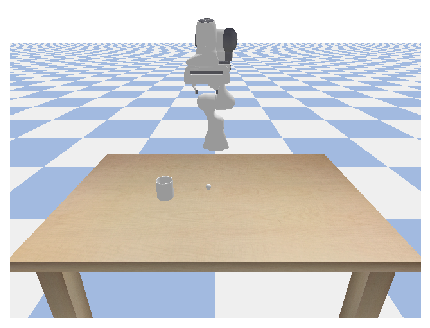

Closing gripper...


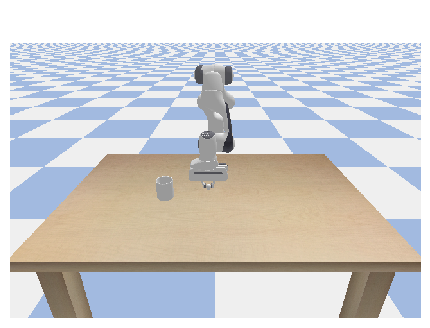

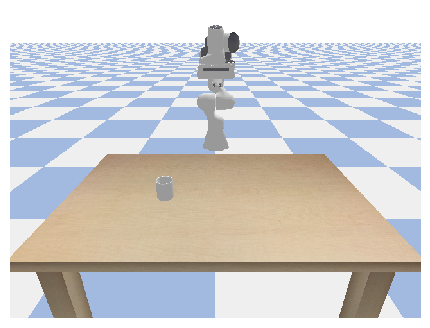

Opening gripper...


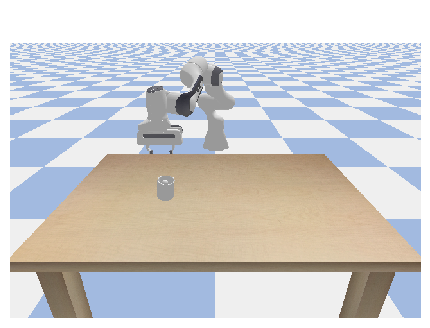

Closing gripper...


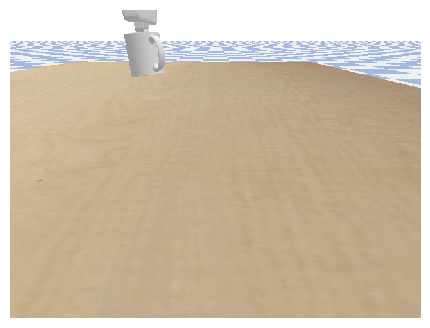

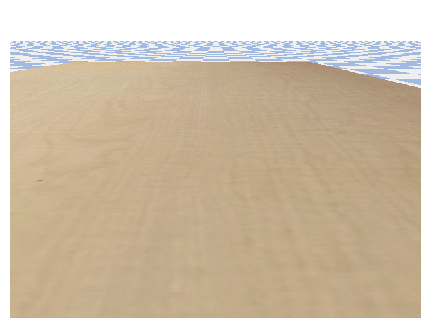

Opening gripper...


In [6]:
try:
	p.disconnect()
except:
	pass

client = p.connect(p.GUI)
# client = p.connect(p.DIRECT)
dt = p.getPhysicsEngineParameters()['fixedTimeStep']
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-9.8)
p.setRealTimeSimulation(0)
p.resetDebugVisualizerCamera(cameraDistance=2.3, cameraYaw=90, cameraPitch=-40, cameraTargetPosition=[0,0,0])
p.loadURDF("plane.urdf")

table = p.loadURDF("table/table.urdf", [0.6, 0, 0], p.getQuaternionFromEuler([0, 0, np.pi/2]), useFixedBase=True)
robot = Robot(p, "franka_panda/panda.urdf", rtb.models.Panda(), [0, 0, 0.63], p.getQuaternionFromEuler([0, 0, 0]))
robot_id = robot.load_model()
robot.reset([0, -0.785, 0, -2.356, 0, 1.571, 0.785, 0, 0])
init_pos = robot.get_ee_pos()[0]

obj1_pos_init = random_pos([0.5, 0.7], [-0.35, 0.35], [0.65, 0.65])
obj1 = p.loadURDF("objects/mug.urdf", obj1_pos_init, p.getQuaternionFromEuler([np.pi/2, 0, np.pi]), useFixedBase=False, globalScaling=0.01)
obj2_pos_init = random_pos([0.55, 0.65], [-0.3, 0.3], [0.63, 0.63])
# obj2 = p.loadURDF("sphere_small.urdf", obj2_pos_init, useFixedBase=False)
obj2 = p.loadURDF("objects/sphere/sphere_small.urdf", obj2_pos_init, useFixedBase=False, globalScaling=0.5)

obj1_pos = p.getBasePositionAndOrientation(obj1)[0]
obj2_pos = p.getBasePositionAndOrientation(obj2)[0]
robot.open_gripper()
robot.go_to_pose([obj2_pos[0], obj2_pos[1], obj2_pos[2]+0.5])
get_image(p, [0, 0, 0.5], 2, [90, -25, 0], fig_size=(8, 4))
robot.go_to_pose([obj2_pos[0], obj2_pos[1], obj2_pos[2]+0.015])
robot.close_gripper()
get_image(p, [0, 0, 0.5], 2, [90, -25, 0], fig_size=(8, 4))
robot.go_to_pose(init_pos)
get_image(p, [0, 0, 0.5], 2, [90, -25, 0], fig_size=(8, 4))
obj1_pos = p.getBasePositionAndOrientation(obj1)[0]
robot.go_to_pose([obj1_pos[0]+0.02, obj1_pos[1], obj1_pos[2]+0.2])
robot.open_gripper()
get_image(p, [0, 0, 0.5], 2, [90, -25, 0], fig_size=(8, 4))
obj1_pos = p.getBasePositionAndOrientation(obj1)[0]
robot.go_to_pose([obj1_pos[0], obj1_pos[1], obj1_pos[2]+0.5])
robot.go_to_pose([obj1_pos[0], obj1_pos[1]-0.05, obj1_pos[2]+0.03])
robot.close_gripper()
get_image(p, [0.5, 0, 0.5], 0.5, [180, -25, 0], fig_size=(8, 4))
robot.go_to_pose([obj1_pos[0], obj1_pos[1], obj1_pos[2]+0.5])
get_image(p, [0.5, 0, 0.5], 0.5, [180, -25, 0], fig_size=(8, 4))
final_pos = random_pos([0.45, 0.75], [-0.4, 0.4], [0.65, 0.65])
robot.go_to_pose([final_pos[0], final_pos[1], final_pos[2]+0.5])
robot.go_to_pose(final_pos)
final_pos = random_pos([0.55, 0.65], [-0.3, 0.3], [0.65, 0.65])
robot.open_gripper()
final_pos = random_pos([0.55, 0.65], [-0.3, 0.3], [0.65, 0.65])
robot.go_to_pose(init_pos)
final_pos = random_pos([0.55, 0.65], [-0.3, 0.3], [0.65, 0.65])


if p.getConnectionInfo(client)['connectionMethod'] == p.GUI:
	while p.isConnected():
		p.stepSimulation()
		time.sleep(dt)
try:
	p.disconnect()
except:
	pass